In [26]:
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px

from classBanditsDynamic import Bandits

In [78]:
import classBanditsKalman
classBanditsKalman.Bandits

classBanditsKalman.Bandits

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

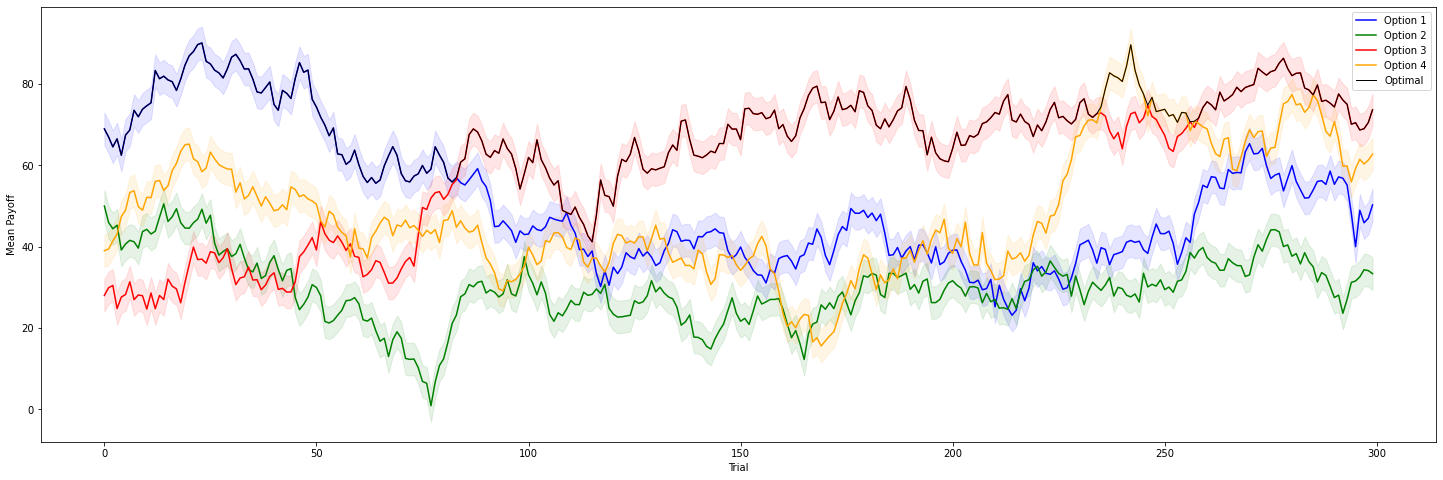

In [30]:
''' Initialising simulation class from loaded payoff function, calculating optimal solution, and printing loaded payoff function'''
total_time = 300
simu = Bandits(total_time)
payoffs = np.genfromtxt('payoffs/payoffs4.csv',delimiter=',')
[_, optimal_scores,_] = simu.findRegret(payoffs,0)
simu.options = len(payoffs)

# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.legend()
plt.show()

In [4]:
''' Payoff generation and saving code '''
payoffs = np.zeros([4,300])
for i in range(300):
    payoffs[1,i] = 50
    payoffs[0,i] = 30#(10 if i < 150 else 70)
    payoffs[2,i] = 70
    payoffs[3,i] = 90#i/300 * 50 + 25

# payoffs = simu.genMeans(15)
np.savetxt('payoffs\payoffs_constant.csv',payoffs,delimiter=',')

In [33]:
''' Simulating trials with the loaded payoff function for the strategies: pure exploitation, discounted softmax, discounted UCB1.
    The optimal sampling proportion from each of the options is also shown, and compared to with the proportions sampled by the softmax and UCB algorithms.'''

exploit_reward = simu.exploit(payoffs,1000)
[exploit_regret, _, optimal_choices] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploit Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))
unique, counts = np.unique(optimal_choices, return_counts = True)
print('Proportions sampled (optimal):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARMAS: 1, 0.995
# PAYOFF 4 PARAMS: 3.55, 0.99
# STEP 1 PARAMS: 1.6, 0.99
# STEP 2 PARAMS: 3, 0.97
softmax_scores, softmax_choices,softmax_history = simu.softmax(payoffs,1,0.8,100)
[softmax_regret, _, _] = simu.findRegret(payoffs,np.sum(softmax_scores,1))
print('Pure Softmax Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))
unique, counts = np.unique(softmax_choices, return_counts = True)
print('Proportions sampled (softmax):   ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

# PAYOFF 1 PARAMS: 1, 0.995
# PAYOFF 4 PARAMS: 4.6, 0.99
# STEP 1 PARAMS: 2.3, 0.99
# STEP 2 PARAMS: 3, 0.96
dUCB_scores, dUCB_choices,dUCB_history = simu.dUCB1(payoffs,1,0.995,100)
[dUCB_regret, _, _] = simu.findRegret(payoffs,np.sum(dUCB_scores,1))
print('Softmax + UCB Mean Regret: %s'% np.mean(dUCB_regret),', Std: %s'% np.std(dUCB_regret))
unique, counts = np.unique(dUCB_choices, return_counts = True)
print('Proportions sampled (softmax + IB):  ',(', ').join([colors[int(unique[i])] +': '+str(round(counts[i]/sum(counts),2)) for i in range(len(counts))])+'\n')

Pure exploit Mean Regret: 0.2806216445890989 , Std: 0.003224573728281439
Proportions sampled (optimal):    blue: 0.28, red: 0.65, orange: 0.07

Pure Softmax Mean Regret: 0.23057427787572696 , Std: 0.006896367847064475
Proportions sampled (softmax):    blue: 0.22, green: 0.17, red: 0.33, orange: 0.28



TypeError: dUCB1() missing 1 required positional argument: 'trials'

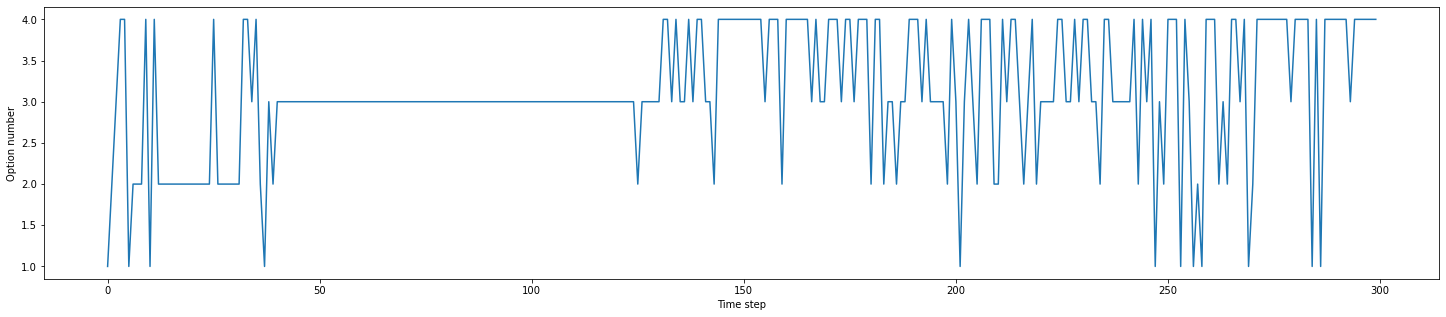

In [6]:
''' Plotting the choice history for one trial under the specific algorithm used. '''
fig,ax = plt.subplots(figsize=(25,5))
trial = 3
plt.plot(dUCB_choices[trial,:]+1) # getting into range 1,2,3,4
plt.xlabel('Time step')
plt.ylabel('Option number')
plt.show()

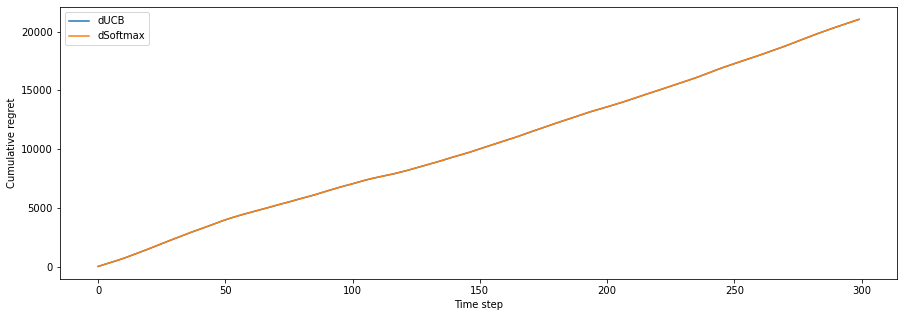

' Main issue: the dUCB + softmax and pure softmax algorithms have the same regret curve'

In [32]:
fig,ax = plt.subplots(figsize=(15,5))
trial = 1
optimal_cum = np.cumsum(optimal_scores)
dUCB_scoresT = np.transpose(dUCB_scores)
softmax_scoresT = np.transpose(softmax_scores)

plt.plot(optimal_cum - np.cumsum(np.mean(dUCB_scoresT)),label='dUCB')
plt.plot(optimal_cum - np.cumsum(np.mean(softmax_scoresT)),label='dSoftmax')

plt.legend()
plt.xlabel('Time step')
plt.ylabel('Cumulative regret')
plt.show()

''' Main issue: the dUCB + softmax and pure softmax algorithms have the same regret curve'''


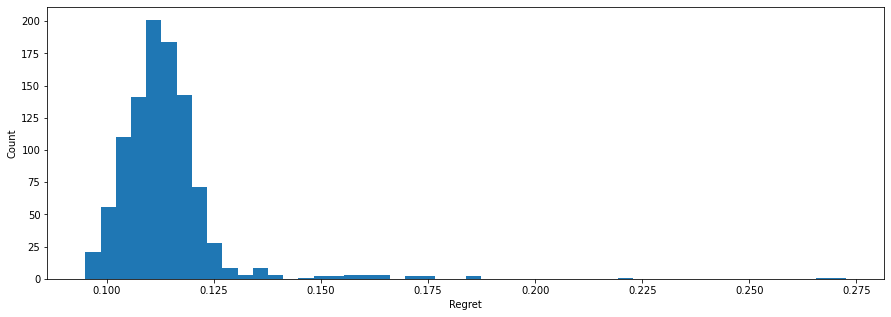

[0.11360687337391558, 0.11235687176665471]


In [9]:
''' Plotting the regret distribution over all the trials taken under a specific algorithm. '''
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(dUCB_regret,50) 
plt.xlabel('Regret')
plt.ylabel('Count')
plt.show()
print([np.mean(dUCB_regret),np.median(dUCB_regret)])

In [206]:
''' Computing optimal parameters for each algorithm by looping over ranges'''
regret_list = np.zeros(10)
params = np.linspace(0.1,3,10)
for i in range(10):
    reward, choices,_ = simu.softmax(payoffs,params[i],0.98,100)
    [regret, _,_] = simu.findRegret(payoffs,reward)
    regret_list[i] = np.mean(regret)
optimal_temp = params[np.argmin(regret_list)]
print('Optimal temp: ', optimal_temp)
print('Softmax Mean Regret: %s'% regret_list[np.argmin(regret_list)]) # 3.2632: 0.1223


C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: overflow encountered in exp
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_10116\1048155955.py:53: RuntimeWarning: invalid value encountered in true_divide
  weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])


Optimal temp:  3.0
Softmax Mean Regret: 0.23489829321547429


In [73]:
time,trials = 6,4

scores = np.zeros([trials,time])
# history = {idx:np.zeros([trials,self.time]) for idx in range(self.options)}       # History of priors: need this to be a single vector
history = np.zeros([trials,time,simu.options])
history_var = np.zeros([trials,time,simu.options])

for option in range(simu.options):
    scores[:,option] = simu.sample(np.zeros(trials) + payoffs[option,0])
    history_var[:,0,option] = np.zeros(trials) + 4
    history[:,0,option] = scores[:,option]
for t in range(1, time-simu.options+1):
    payoff_priors = history[:,t-1,:]
    weights = np.exp(payoff_priors) / np.sum(np.exp(payoff_priors),1).reshape([trials,1])
    chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)
    scores[:,t+simu.options-1] = simu.sample(payoffs[chosen,t])

    pred_err = scores[:,t+simu.options-1] - history[:,t-1,chosen]
    gain = history_var[:,t-1,chosen] / (history_var[:,t-1,chosen] + 4)
    post_mean = history_var[:,t-1,chosen] + gain*pred_err
    post_var = (1-gain)*history_var[:,t-1,chosen]
print(history_var[:,0,:])
print(chosen)
print(post_mean)
print(gain)

[[4. 4. 4.]
 [4. 4. 4.]
 [4. 4. 4.]
 [4. 4. 4.]]
[2 1 0 1]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [2]:
test = [[1,2,3],[4,5,6],[7,8,9]]
test[0][0]=0
print(test)

[[0, 2, 3], [4, 5, 6], [7, 8, 9]]


In [10]:
## Jane street matrix puzzle

final_ans = [
    [4,3,6,5,3,7,4,9,6,5],
    [8,10,2,4,1,1,2,3,8,2],
    [9,2,3,2,1,2,5,1,2,4],
    [5,7,2,1,2,6,3,1,1,3],
    [6,3,1,1,3,2,1,4,2,7],
    [1,1,4,5,1,1,1,3,5,6],
    [3,1,2,3,2,4,2,1,2,3],
    [4,2,1,1,1,1,3,1,4,9],
    [5,8,3,4,2,1,6,2,3,8],
    [7,6,9,10,5,3,4,7,2,5]
]

row_prod = [np.prod(row) for row in final_ans]
mat_sum = np.sum(row_prod)

print(row_prod)
print(mat_sum)



[8164800, 61440, 8640, 7560, 6048, 1800, 1728, 864, 276480, 15876000]
24405360


In [ ]:
def checkSol(final_mat):
    ''' Do a BFS on each cell, and check that there are no repeated numbers in taxicab distance, and there exists at least 1 at the exact correct distance.
    Note: does not account for region errors. Need to check manually or use another data structure containing regional info.
    - Actually, can just iterate over the diamond to check none inside, and at least one on edge.
    '''
